### The Stationarity vs Memory Dilemma

대부분의 금융 시계열 분석은 두가지 상황에서 딜레마에 빠진다
1. Box-Jenkins : log difference 데이터는 정상성을 가지지만, market memory를 가지지 않는다
2. Engle-Granger : log price 계열은 market memory를 가진다. 하지만 비정상성을 얻게 된다. Cointegration은 비정상성 시계열에서 회귀모형을 작동 가능하게 하지만 매우 제한적인 상황에서 발견되며, Cointegration의 안정성도 신뢰가 좋다고는 볼 수 없다

Long memory model은 ADF 검정 결과를 지키는 최소한의 차분계수($d$)통해 market memory와 stationarity를 모두 포함하도록 해 준다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

start_date = '2000-01-01'
end_date = '2024-04-08'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


#### Fractionally differentiated Features

실수값인 feature $\{X_t\}$에 적용한 backshift 연산자 $B$를 가정해 보자. 여기서 $k \geq 0$인 모든 정수에 대해 $B^kX_t = X_{t-k}$이다. 양의 정수 $n$에 $(x+y)^n = \sum_{k=0}^n {n \choose k} x^k y^{n-k} = \sum_{k=0}^n {n \choose k}x^{n-k}k^k$라는 것에 주목하자. 실수 $d$에서 $(1+x)^d = \sum_{k=0}^\infty {d \choose k} x^k$ 즉, 이항 계열이다. Fractionally differentiated model에서 지수 $d$는 실수값이 가능하고, 다음 형식의 이항 계열 확장을 따른다

$$\begin{matrix}
(1-B)^d = \sum_{k=0}^\infty {d \choose k}(-B)^k &=& \sum_{k=0}^\infty \frac{\prod_{i=0}^{k-1}(d-i)}{k!} \\
       &=& \sum_{k=0}^\infty (-B)^k \prod_{i=0}^{k-1}\frac{d-i}{k-i} \\
       &=& 1 - dB + \frac{d(d-1)}{2!}B^2 - \frac{d(d-1)(d-2)}{3!}B^3 + \cdots
\end{matrix}$$

#### Long Memory

양의 실수 $d$가 기억을 유지하는 법을 알아보도록 하자. 아래의 산술 계열은 내적으로 이뤄져 있다

$$\tilde X_t = \sum_{k=0}^\infty \omega_k X_{t-k}$$

여기서 가중값 $\omega$는

$$\omega = \Big\{
1, -d, \frac{d(d-1)}{2!}, -\frac{d(d-1)(d-2)}{3!}, \cdots, (-1)^k \prod_{i=0}^{k-1} \frac{d-i}{k!}, \cdots
\Big\}$$

그리고 값 $X$는

$$X = \{X_t, X_{t-1}, X_{t-2}, X_{t-3}, \dots, X_{t-k}, \dots\}$$

이다.

$d$가 양의 정수일 때 $\prod_{i=0}^{k-1} \frac{d-i}{k!} = 0, \forall k>d$이고, 이 지점을 넘어선 market memory는 소멸된다. 예를들어, $d=1$일 경우 수익률을 계산하기 위해 사용하는 차분계수이다. 여기서 $\prod_{i=0}^{k-1} \frac{d-i}{k!} = 0, \forall k>1$이고 $\omega = \{1,-1,0,0,\cdots \}$이다

가중값 $\omega$의 sequence를 살펴보면 $\omega_0 = 1$이고, $k = 0, \dots, \infty$에 대해서 가중값은 반복적으로 다음과 같이 생성된다.

$$\omega_k = -\omega_{k-1}\frac{d-k+1}{k}$$

#### Stationarity with Maximum Memory Preservation

Time series $\{X_t\}_{t=1, \dots, T}$를 고려해 보자. Fixing-width window fractional difference 방법을 이 계열에 적용하면 Fractional differentiated Series $\{\tilde X_t\}_{t=l^*, \dots, T}$이 정상성을 가지도록 하는 최소의 차분계수 $d^*$를 구할 수 있다. 이 계수는 정상성을 얻기 위해 없애야 하는 기억의 양을 정량화 한다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 이미 stationary하다면 $d^*=0$이다

$\{\tilde X_t\}_{t=l^*, \dots, T}$가 unit root을 가지고 있다면 $d^* <1$이다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 폭발적 행태를 보인다면 $d^* >1$이다. 이 중 $0<d^* <1$인 경우는 원시계열이 약간의 비정상성을 가지는 경우로, 이 경우 정상성을 위해 차분이 필요하지만, 1차 차분을 하게 되면 원시계열에 담겨 있는 market memory와 유의미한 신호를 제거하게 된다

In [2]:
def get_weights(d, size) :
    # thres > 0 유의미하지 않은 가중값을 제거
    w = [1.]
    for k in range(1, size) :
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def plot_weights(d_range, n_plots, size) :
    w = pd.DataFrame()
    for d in np.linspace(d_range[0], d_range[1], n_plots) :
        w_ = get_weights(d, size)
        w_ = pd.DataFrame(w_, index = range(w_.shape[0])[::-1], columns = [d])
        w = w.join(w_, how = 'outer')
    ax = w.plot()
    plt.grid(False)
    ax.legend(loc = 'upper right')
    plt.show()
    return None

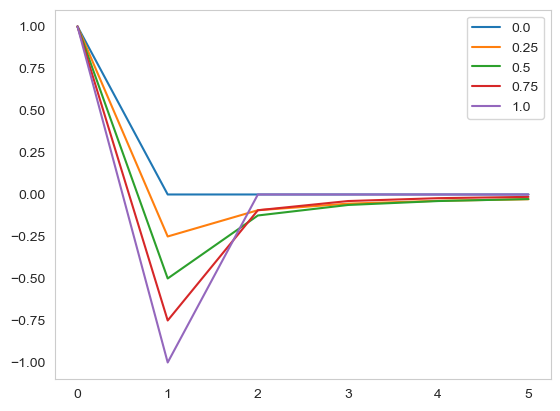

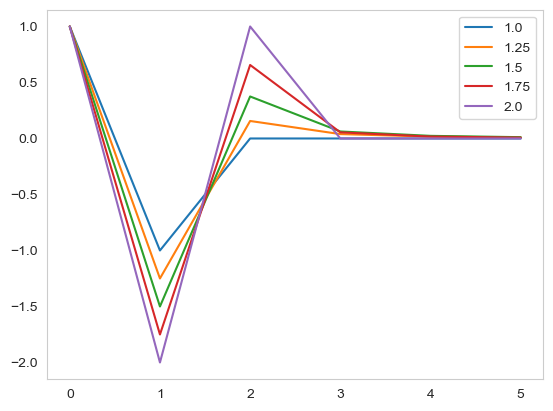

In [3]:
if __name__ == '__main__' :
    plot_weights(d_range = [0, 1], n_plots = 5, size = 6)
    plot_weights(d_range = [1, 2], n_plots = 5, size = 6)

In [4]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 1, 21):
    try:
        df1 = data[['Adj Close']]
        df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d = d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index,'Adj Close'], df2['Adj Close'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['Adj Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[round(d, 2)] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {round(d, 2)}, error: {e}')
        continue

d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.15, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.25, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


In [5]:
out

,adfStat,pVal,lags,nObs,95% conf,corr
0.00,1.023018,9.945030e-01,1.0,6100.0,-2.862014,1.000000
0.30,-2.171095,2.169030e-01,1.0,5.0,-3.929280,0.899639
0.35,-2.583663,9.642104e-02,1.0,8.0,-3.367187,0.749462
0.40,-2.596647,9.369219e-02,1.0,12.0,-3.154972,0.841751
0.45,-3.275113,1.602822e-02,1.0,19.0,-3.031227,0.824640
0.50,-2.954195,3.939911e-02,1.0,31.0,-2.960525,0.521058
0.55,-3.760207,3.341720e-03,1.0,50.0,-2.921360,0.600201
0.60,-3.991200,1.457299e-03,1.0,81.0,-2.897943,0.614946
0.65,-4.516111,1.838710e-04,1.0,133.0,-2.883528,0.478610
0.70,-6.519115,1.053004e-08,1.0,223.0,-2.874590,0.392316


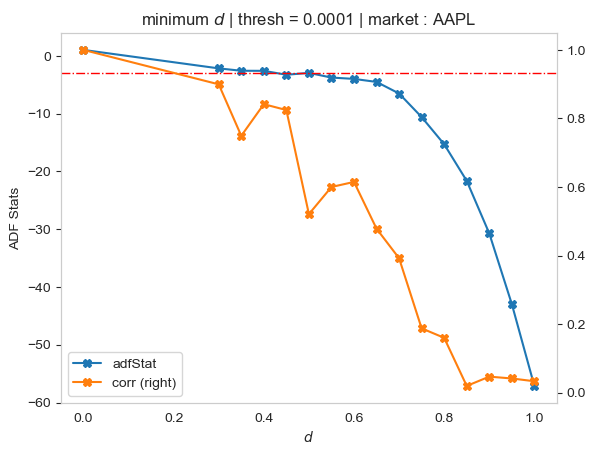

In [6]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
ax.set_title(r'minimum $d$ | thresh = 0.0001 | market : AAPL')
ax.set_xlabel(r'$d$')
ax.grid(False)
ax.set_ylabel('ADF Stats')
plt.show()

In [7]:
frac_close = FractionalDifferentiatedFeatures.fracDiff(data[['Adj Close']], 0.45)

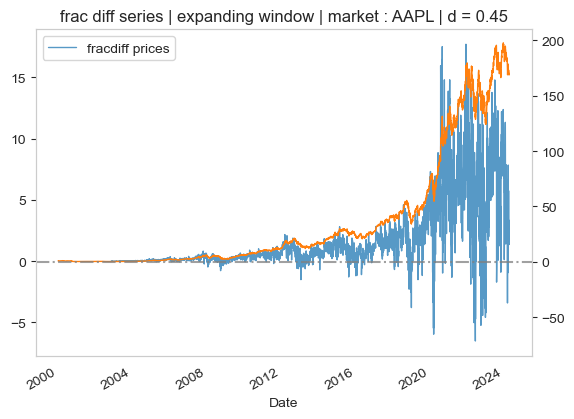

In [21]:
frac_close['Adj Close'].plot(alpha = 0.75, lw = 1)
plt.grid(False)
plt.legend(['fracdiff prices'])
data['Adj Close'].plot(secondary_y = True, lw = 1, alpha = 1)
plt.ylim([-85, 210])
plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
plt.grid(False)
plt.title('frac diff series | expanding window | market : AAPL | d = 0.45')
plt.show()

In [9]:
frac_close_ffd = FractionalDifferentiatedFeatures.fracDiff_FFD(data[['Adj Close']], 0.45)

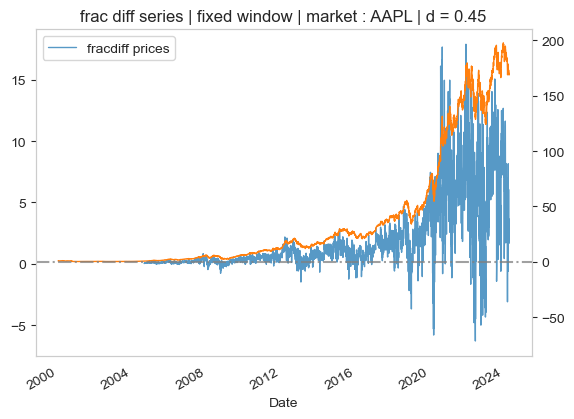

In [25]:
frac_close_ffd['Adj Close'].plot(alpha = 0.75, lw = 1)
plt.grid(False)
plt.legend(['fracdiff prices'])
data['Adj Close'].plot(secondary_y = True, lw = 1, alpha = 1)
plt.grid(False)
plt.ylim([-85, 210])
plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
plt.title('frac diff series | fixed window | market : AAPL | d = 0.45')
plt.show()

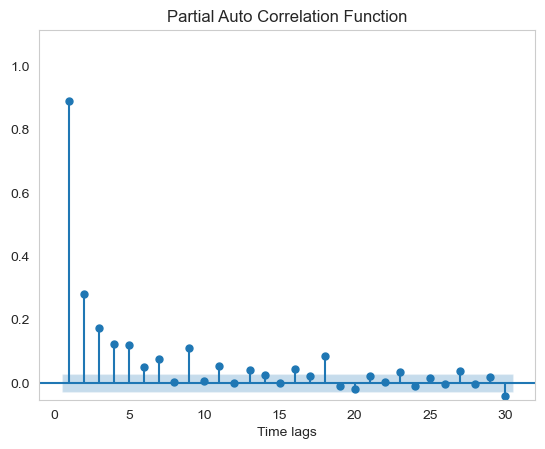

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(
    frac_close_ffd['Adj Close'], 
    auto_ylims = True, 
    lags = range(1, 31)
)
plt.grid(False)
plt.xlabel('Time lags')
plt.title('Partial Auto Correlation Function')
plt.show()

In [33]:
import warnings
warnings.filterwarnings('ignore')

arima = sm.tsa.ARIMA(
    frac_close_ffd['Adj Close'], 
    order = (18,0,0), 
    trend = 'c'
).fit(method = 'innovations_mle')

In [34]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 4941
Model:                ARIMA(18, 0, 0)   Log Likelihood               -8092.898
Date:                Wed, 10 Apr 2024   AIC                          16225.796
Time:                        11:54:06   BIC                          16355.902
Sample:                             0   HQIC                         16271.424
                               - 4941                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9661      0.995      1.976      0.048       0.016       3.916
ar.L1          0.5377      0.007     82.720      0.000       0.525       0.550
ar.L2          0.1085      0.007     14.969      0.000       0.094       0.123
ar.L3          0.0766      0.008      9.868      0.000       0.061       0.092
ar.L4          0.0270      0.007      3.899      0.000       0.013       0.041
ar.L5          0.0709      0.007     10.194      0.000       0.057       0.085
ar.L6         -0.0021      0.008     -0.274      0.784      -0.017       0.013
ar.L7          0.0514      0.008      6.565      0.000       0.036       0.067
ar.L8         -0.0616      0.007     -8.340      0.000      -0.076      -0.047
ar.L9          0.0870      0.007     12.405      0.000       0.073       0.101
ar.L10        -0.0242      0.007     -3.358      0.001      -0.038      -0.010
ar.L11         0.0394      0.008      5.130      0.000       0.024       0.054
ar.L12        -0.0270      0.008     -3.593      0.000      -0.042      -0.012
ar.L13         0.0177      0.007      2.394      0.017       0.003       0.032
ar.L14         0.0170      0.008      2.226      0.026       0.002       0.032
ar.L15        -0.0337      0.008     -4.277      0.000      -0.049      -0.018
ar.L16         0.0253      0.008      3.101      0.002       0.009       0.041
ar.L17        -0.0254      0.008     -3.374      0.001      -0.040      -0.011
ar.L18         0.0864      0.007     12.368      0.000       0.073       0.100
sigma2         1.5488      0.011    137.121      0.000       1.527       1.571
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             47969.43
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):             360.68   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""